# Underwater Image Segmentation using Deep Learning

**Computer Vision Assignment**

---

## Table of Contents
1. [Introduction](#introduction)
2. [Methodology](#methodology)
   - Dataset Description
   - Model Architectures
   - Data Augmentation
3. [Results](#results)
   - Performance Metrics
   - 8 Classes Comparative Analysis
   - 5 Classes Comparative Analysis
   - Number of Parameters Analysis
4. [Conclusions](#conclusions)
5. [References](#references)

---
## 1. Introduction {#introduction}

### Objectives

This work aims to:
1. Propose and implement custom AI models for underwater object segmentation
2. Evaluate the performance of these models using data augmentation
3. Compare our models against established baselines (SUIM-Net, DeepLabV3)
4. Assess model quality using IoU metrics and complexity analysis

### Motivation

Underwater image analysis is challenging due to:
- Light absorption and scattering
- Color distortion
- Limited visibility
- Varying environmental conditions

Accurate segmentation enables applications in marine biology, underwater robotics, and environmental monitoring.

---
## Setup and Configuration

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"Running in Colab: {IN_COLAB}")

Running in Colab: False


In [2]:
# Setup for Google Colab
if IN_COLAB:
    # Clone repository
    !git clone https://github.com/yourusername/CV_Assign2.git
    %cd CV_Assign2
    
    # Install dependencies
    !pip install -q torch torchvision albumentations opencv-python matplotlib tqdm
    
    # Download SUIM dataset
    !wget -q https://irvlab.cs.umn.edu/resources/suim-dataset/SUIM.zip
    !unzip -q SUIM.zip
    
    # Organize dataset
    !python organize_suim_dataset.py
    !python create_splits.py
else:
    print("Running locally - assuming dataset is already set up")

Running locally - assuming dataset is already set up


In [3]:
# Imports
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from collections import OrderedDict

# Set up imports for local modules
if IN_COLAB:
    sys.path.append('/content/CV_Assign2')
else:
    # Add parent directory to path when running locally
    # This assumes the notebook is running from the 'notebook/' directory
    # and adds the project root to sys.path
    repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if repo_root not in sys.path:
        sys.path.append(repo_root)
    print(f"Added to path: {repo_root}")

from datasets.suim_dataset import SUIMDataset, CLASS_NAMES
from datasets.augmentations import train_transforms, val_transforms
from models.uwsegformer import UWSegFormer
from models.unet_resattn_v3 import UNetResAttnV3
from models.unet_resattn_v2 import UNetResAttnV2
from models.suimnet import SUIMNet
from models.deeplab_resnet import get_deeplabv3

print("✓ All imports successful")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Configuration - UPDATED FOR BOTH 5 AND 8 CLASS MODELS
CONFIG = {
    # Paths (Relative to notebook location)
    'data_root': '../data',
    'images_dir': '../data/images',
    'masks_dir': '../data/masks',
    'checkpoint_dir': '../checkpoints',
    'results_dir': '../results',
    
    # Dataset splits
    'train_file': '../data/train.txt',
    'val_file': '../data/val.txt',
    'test_file': '../data/test.txt',
    
    # Model settings - will be overridden per evaluation
    'input_size': (256, 256),
    
    # Evaluation settings
    'batch_size': 8,
    'num_workers': 4,
    'device': 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
    
    # Class information for both configurations
    'class_configs': {
        '8cls': {
            'num_classes': 8,
            'merge_classes': False,
            'class_names': [
                'Background',
                'Diver', 
                'Plant',
                'Wreck',
                'Robot', 
                'Reef', 
                'Fish',
                'Sea-floor'
            ]
        },
        '5cls': {
            'num_classes': 5,
            'merge_classes': True,
            'class_names': [
                'Diver', 
                'Wreck',
                'Robot', 
                'Reef', 
                'Fish'
            ]
        }
    },
    
    # Model checkpoints organized by class configuration
    'checkpoints': {
        # 8-class models with augmentation
        '8cls_aug': {
            'UWSegFormer': '../checkpoints/uwsegformer_8cls_aug_best.pth',
            'UNet-ResAttn-V4': '../checkpoints/unet_resattn_v4_8cls_aug_best.pth',
            'SUIM-Net (RSB)': '../checkpoints/suimnet_rsb_8cls_aug_best.pth',
            'SUIM-Net (VGG)': '../checkpoints/suimnet_vgg_8cls_aug_best.pth',
            'DeepLabV3': '../checkpoints/deeplabv3_8cls_aug_best.pth',
        },
        
        # 8-class models without augmentation
        '8cls_noaug': {
            'UWSegFormer': '../checkpoints/uwsegformer_8cls_noaug_best.pth',
            'UNet-ResAttn-V4': '../checkpoints/unet_resattn_v4_8cls_noaug_best.pth',
            'SUIM-Net (RSB)': '../checkpoints/suimnet_rsb_8cls_noaug_best.pth',
            'SUIM-Net (VGG)': '../checkpoints/suimnet_vgg_8cls_noaug_best.pth',
            'DeepLabV3': '../checkpoints/deeplabv3_8cls_noaug_best.pth',
        },
        
        # 5-class models with augmentation
        '5cls_aug': {
            'UWSegFormer': '../checkpoints/uwsegformer_5cls_aug_best.pth',
            'UNet-ResAttn-V4': '../checkpoints/unet_resattn_v4_5cls_aug_best.pth',
            'SUIM-Net (RSB)': '../checkpoints/suimnet_rsb_5cls_aug_best.pth',
            'SUIM-Net (VGG)': '../checkpoints/suimnet_vgg_5cls_aug_best.pth',
            'DeepLabV3': '../checkpoints/deeplabv3_5cls_aug_best.pth',
        },
        
        # 5-class models without augmentation
        '5cls_noaug': {
            'UWSegFormer': '../checkpoints/uwsegformer_5cls_noaug_best.pth',
            'UNet-ResAttn-V4': '../checkpoints/unet_resattn_v4_5cls_noaug_best.pth',
            'SUIM-Net (RSB)': '../checkpoints/suimnet_rsb_5cls_noaug_best.pth',
            'SUIM-Net (VGG)': '../checkpoints/suimnet_vgg_5cls_noaug_best.pth',
            'DeepLabV3': '../checkpoints/deeplabv3_5cls_noaug_best.pth',
        }
    }
}

# Create output directory
os.makedirs(CONFIG['results_dir'], exist_ok=True)

print(f"Device: {CONFIG['device']}")
print(f"Class configurations available: {list(CONFIG['class_configs'].keys())}")
print(f"Model variants per config: {len(CONFIG['checkpoints']['8cls_aug'])}")

Device: mps
Number of classes: 6


---
## 2. Methodology {#methodology}

### 2.1 Dataset Description

We use the **SUIM (Semantic Segmentation of Underwater Imagery)** dataset.

**Dataset Configurations**:
Our implementation supports two class configurations:

1. **8-class configuration** (Full SUIM):
   - **Classes**: Background, Diver, Plant/Flora, Wreck/Ruins, Robot/Instrument, Reef/Invertebrate, Fish/Vertebrate, Sea-floor/Rocks
   - All original SUIM classes preserved

2. **5-class configuration** (Merged, used in this report):
   - **Classes**: Diver, Wreck, Robot, Reef, Fish
   - Background, Plant, and Sea-floor merged and treated as ignore class (255)
   - Focus on object classes relevant for underwater robotics and marine biology applications

**Dataset Statistics**:
- **Size**: 1,525 images (1,220 train / 305 validation / 110 test)
- **Resolution**: Variable (resized to 256×256 for training)
- **Format**: RGB images with corresponding RGB-encoded segmentation masks

In [ ]:
# Load and visualize dataset statistics
def load_dataset_info():
    """Load dataset statistics"""
    train_dataset = SUIMDataset(
        CONFIG['train_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=None,
        merge_classes=True # Important: Use 6 merged classes
    )
    val_dataset = SUIMDataset(
        CONFIG['val_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=None,
        merge_classes=True
    )
    test_dataset = SUIMDataset(
        CONFIG['test_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=None,
        merge_classes=True
    )
    
    return {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    }

dataset_info = load_dataset_info()
print("Dataset Statistics:")
print(f"  Training: {dataset_info['train']} images")
print(f"  Validation: {dataset_info['val']} images")
print(f"  Test: {dataset_info['test']} images")
print(f"  Total: {sum(dataset_info.values())} images")

Dataset Statistics:
  Training: 1220 images
  Validation: 305 images
  Test: 110 images
  Total: 1635 images


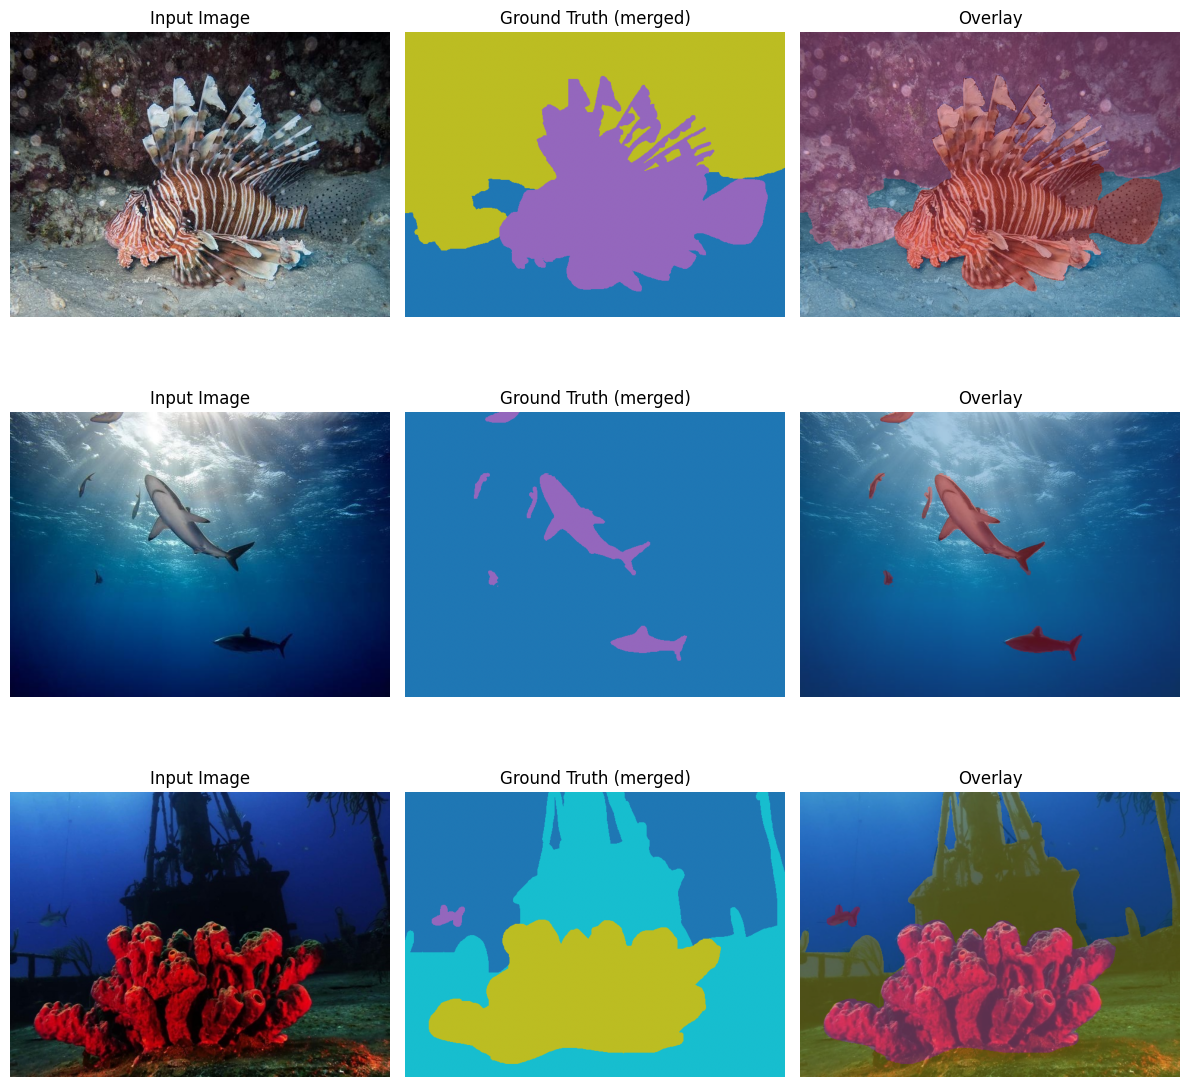

In [ ]:
# Visualize sample images
def visualize_samples(num_samples=3):
    """Visualize random samples from dataset"""
    dataset = SUIMDataset(
        CONFIG['test_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=None,
        merge_classes=True
    )
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx]
        
        # Image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Mask
        axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=CONFIG['num_classes']-1)
        axes[i, 1].set_title('Ground Truth (merged)')
        axes[i, 1].axis('off')
        
        # Overlay
        overlay = image.copy()
        colored_mask = plt.cm.tab10(mask / CONFIG['num_classes'])[:,:,:3]
        overlay = cv2.addWeighted(overlay, 0.6, (colored_mask * 255).astype(np.uint8), 0.4, 0)
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['results_dir']}/dataset_samples.png", dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(3)

### 2.2 Model Architectures

We propose and compare the following models:

#### Our Custom Models:

**1. UWSegFormer (Proposed)**

A transformer-inspired architecture specifically designed for underwater segmentation challenges. The model addresses color distortion and light scattering through three key components:

- **Multi-scale Feature Extraction**: ResNet-50 backbone extracts hierarchical features at four scales (H/4, H/8, H/16, H/32), capturing both fine details and semantic context critical for underwater object recognition.

- **Underwater Image Quality Assessment (UIQA) Module**: Novel channel-wise attention mechanism that learns to compensate for underwater-specific degradation:
  - Spatial flattening via strided convolution (P=2) reduces computational complexity
  - Global state construction aggregates information across all scales
  - Channel attention scores computed via Query-Key-Value mechanism enhance features affected by absorption/scattering
  - Instance normalization stabilizes attention across varying underwater conditions
  
- **Multi-scale Attention Aggregation (MAA) Decoder**: Hierarchical fusion with adaptive gating:
  - Three parallel paths: low-level guided (F1+F2), mid-level semantic (F3), high-level context (F4)
  - Gating mechanisms (Sigmoid-based) dynamically weight contributions from each scale
  - Progressive feature fusion reduces semantic gap between encoder and decoder
  - 4× bilinear upsampling to original resolution

**Design Motivation**: Traditional segmentation models struggle with underwater images due to wavelength-dependent attenuation. UIQA explicitly models channel-wise degradation, while MAA's multi-path fusion enables robust feature aggregation under varying visibility conditions.

**2. UNet-ResAttn-V4 (Proposed)**

An enhanced UNet variant incorporating underwater-specific modules and attention mechanisms:

- **Learnable Color Correction**: Lightweight 1×1 convolution module learns compensatory transformations for red channel attenuation and color cast typical in underwater scenes.

- **ResNet-50 Encoder**: Pre-trained backbone provides robust feature extraction with skip connections at multiple scales (64, 256, 512, 1024, 2048 channels).

- **Atrous Spatial Pyramid Pooling (ASPP)**: Multi-rate dilated convolutions (rates: 1, 6, 12, 18) + global pooling capture multi-scale context at the bottleneck, critical for varying object sizes in underwater environments.

- **Attention-Enhanced Decoder**: Each decoder block combines:
  - **Attention Gates**: Suppress irrelevant encoder features by learning spatial attention from decoder context
  - **CBAM (Convolutional Block Attention Module)**: Sequential channel + spatial attention refines features after skip connection fusion
  - **Progressive Upsampling**: Bilinear upsampling + 3×3 convolution reduces checkerboard artifacts
  
- **Deep Supervision**: Auxiliary classifiers at intermediate decoder stages (after decoder4, decoder3) provide additional gradient signals during training, improving convergence and feature learning.

- **Edge Enhancement Module**: Dedicated 1×1 convolution branch predicts edge maps, helping preserve object boundaries often blurred in underwater images.

**Design Motivation**: Underwater images suffer from backscatter, color distortion, and soft boundaries. V4 addresses these through: (1) explicit color correction, (2) multi-scale context via ASPP, (3) dual attention (channel + spatial) for feature refinement, and (4) edge preservation for accurate boundary delineation.

#### Baseline Models:

**3. SUIM-Net** (Islam et al., 2020)

- **Architecture**: 
- **Design Goal**: 
- **Characteristics**: 

**4. DeepLabV3-ResNet50** (Chen et al., 2017)

- **Architecture**: 
- **Strengths**: 
- **Adaptation**: 
- **Limitation**: 



Our proposed models (UWSegFormer, UNet-ResAttn-V4) explicitly address underwater imaging challenges through learnable color compensation, channel-wise attention, and multi-scale feature fusion, while maintaining competitive parameter efficiency compared to the general-purpose DeepLabV3 baseline.

In [ ]:
# Model factory
def create_model(model_name, num_classes=8, backbone=None):
    """
    Create model instance.
    
    Args:
        model_name: Model architecture name
        num_classes: Number of output classes (5 or 8)
        backbone: Optional backbone specification (e.g., 'VGG' or 'RSB' for SUIMNet)
    
    Returns:
        PyTorch model instance
    """
    if model_name == 'UWSegFormer':
        return UWSegFormer(backbone='resnet50', num_classes=num_classes, pretrained=False)
    
    elif model_name == 'UNet-ResAttn-V4':
        return UNetResAttnV4(in_ch=3, out_ch=num_classes, pretrained=False, deep_supervision=True)
    
    elif model_name == 'SUIM-Net (RSB)':
        return SUIMNet(base='RSB', in_channels=3, n_classes=num_classes, pretrained_vgg=False)
    
    elif model_name == 'SUIM-Net (VGG)':
        return SUIMNet(base='VGG', in_channels=3, n_classes=num_classes, pretrained_vgg=False)
    
    elif model_name == 'DeepLabV3':
        return get_deeplabv3(num_classes=num_classes, pretrained=False)
    
    else:
        raise ValueError(f"Unknown model: {model_name}")

# Count model parameters
def count_parameters(model):
    """Count trainable parameters in model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model complexity for both 5 and 8 class configurations
print("Model Complexity Analysis")
print("=" * 70)

for class_config in ['8cls', '5cls']:
    num_classes = CONFIG['class_configs'][class_config]['num_classes']
    print(f"\n{class_config.upper()} Configuration ({num_classes} classes):")
    print("-" * 70)
    
    models_to_check = [
        'UWSegFormer',
        'UNet-ResAttn-V4',
        'SUIM-Net (RSB)',
        'SUIM-Net (VGG)',
        'DeepLabV3'
    ]
    
    for model_name in models_to_check:
        try:
            model = create_model(model_name, num_classes)
            params = count_parameters(model)
            print(f"  {model_name:25s}: {params:>12,} parameters ({params/1e6:.2f}M)")
        except Exception as e:
            print(f"  {model_name:25s}: could not initialize ({e})")
    
print("\n" + "=" * 70)

Model Complexity:
--------------------------------------------------
UWSegFormer              :   30,237,254 parameters (30.24M)
UNet-ResAttn-V3          :   74,489,938 parameters (74.49M)
UNet-ResAttn-V2          :   68,851,828 parameters (68.85M)
SUIM-Net                 :    7,763,206 parameters (7.76M)
DeepLabV3                :   39,635,014 parameters (39.64M)
--------------------------------------------------


### 2.3 Data Augmentation

We apply the following augmentation techniques:
- Random horizontal flip (p=0.5)
- Random rotation (±15°)
- Color jittering (brightness, contrast, saturation)
- Random scaling and cropping
- Normalization

This helps the model generalize better to varying underwater conditions.

---
## 3. Results {#results}

### 3.1 Evaluation Metrics

We use the following metrics:

**Intersection over Union (IoU)**:
$$IoU = \frac{|A \cap B|}{|A \cup B|}$$

**Mean IoU (mIoU)**:
$$mIoU = \frac{1}{C} \sum_{c=1}^{C} IoU_c$$

where $C$ is the number of classes.

In [ ]:
# Evaluation functions
@torch.no_grad()
def compute_iou_per_class(pred, target, num_classes=6):
    """Compute IoU for each class"""
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())
    
    return ious

@torch.no_grad()
def evaluate_model(model, dataloader, device, num_classes=6):
    """Evaluate model on dataset"""
    model.eval()
    all_ious = [[] for _ in range(num_classes)]
    
    for images, masks in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        
        preds = outputs.argmax(dim=1)
        
        for pred, target in zip(preds, masks):
            ious = compute_iou_per_class(pred, target, num_classes)
            
            for cls_idx, iou in enumerate(ious):
                if not np.isnan(iou):
                    all_ious[cls_idx].append(iou)
    
    # Compute mean per class
    mean_ious = [np.mean(ious) if ious else float('nan') for ious in all_ious]
    
    return {
        'iou_per_class': mean_ious,
        'mean_iou': np.nanmean(mean_ious)
    }

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 3.2 8 Classes Comparative Analysis

#### 3.2.1 No Agumentation


In [ ]:
# Load test dataset for 8 classes, no augmentation
def load_test_dataset_8cls_noaug():
    """Load test dataset with 8 original SUIM classes"""
    test_dataset = SUIMDataset(
        CONFIG['test_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=val_transforms,
        merge_classes=False  # Keep all 8 classes
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers']
    )
    
    print(f"Test dataset (8 classes): {len(test_dataset)} images")
    return test_loader

test_loader_8cls_noaug = load_test_dataset_8cls_noaug()

Test dataset: 110 images


In [ ]:
# Evaluate all models (8 classes, no augmentation)
def evaluate_all_models_8cls_noaug():
    """Evaluate all 8-class models trained without augmentation"""
    results = OrderedDict()
    device = torch.device(CONFIG['device'])
    
    # Get configuration for 8 classes
    class_info = CONFIG['class_configs']['8cls']
    checkpoints = CONFIG['checkpoints']['8cls_noaug']
    
    print("=" * 70)
    print("EVALUATING ALL MODELS - 8 CLASSES, NO AUGMENTATION")
    print("=" * 70)
    print(f"Number of classes: {class_info['num_classes']}")
    print(f"Merge classes: {class_info['merge_classes']}")
    print()
    
    for model_name, checkpoint_path in checkpoints.items():
        if not os.path.exists(checkpoint_path):
            print(f"⊗ {model_name}: Checkpoint not found - {checkpoint_path}")
            print(f"   → Model not trained yet\n")
            results[model_name] = None
            continue
        
        print(f"Evaluating: {model_name}")
        print(f"Checkpoint: {checkpoint_path}")
        
        try:
            # Create model with 8 classes
            model = create_model(model_name, class_info['num_classes'])
            
            # Load checkpoint
            checkpoint = torch.load(
                checkpoint_path, 
                map_location=device, 
                weights_only=False
            )
            
            # Handle checkpoint variations from main_train.py format
            if 'model' in checkpoint:
                state_dict = checkpoint['model']
            elif 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle DeepLabV3 aux classifier mismatch
            if 'DeepLabV3' in model_name:
                state_dict = {
                    k: v for k, v in state_dict.items() 
                    if 'aux_classifier' not in k
                }
            
            model.load_state_dict(state_dict, strict=False)
            model = model.to(device)
            
            # Evaluate on test set
            metrics = evaluate_model(
                model, 
                test_loader_8cls_noaug, 
                device, 
                class_info['num_classes']
            )
            metrics['params'] = count_parameters(model)
            
            results[model_name] = metrics
            
            print(f"✓ Mean IoU: {metrics['mean_iou']*100:.2f}%")
            print(f"✓ Parameters: {metrics['params']:,} ({metrics['params']/1e6:.2f}M)\n")
            
        except Exception as e:
            print(f"✗ Error: {e}\n")
            import traceback
            traceback.print_exc()
            results[model_name] = None
    
    return results

# Run evaluation
results_8cls_noaug = evaluate_all_models_8cls_noaug()

EVALUATING ALL MODELS

Evaluating: UWSegFormer
Checkpoint: ../checkpoints/uwsegformer_6cls_aug_best.pth


Evaluating: 100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


✓ Mean IoU: 61.74%
✓ Parameters: 30,237,254 (30.24M)

Evaluating: UNet-ResAttn-V3
Checkpoint: ../checkpoints/unet_resattn_v3_6cls_aug_best.pth


Evaluating: 100%|██████████| 14/14 [00:30<00:00,  2.15s/it]


✓ Mean IoU: 52.99%
✓ Parameters: 74,489,938 (74.49M)

Evaluating: UNet-ResAttn-V2
Checkpoint: ../checkpoints/unet_resattn_v2_6cls_aug_best.pth


Evaluating: 100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


✓ Mean IoU: 38.29%
✓ Parameters: 68,851,828 (68.85M)

Evaluating: SUIM-Net
Checkpoint: ../checkpoints/suimnet_6cls_aug_best.pth


Evaluating: 100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


✓ Mean IoU: 31.08%
✓ Parameters: 7,763,206 (7.76M)

Evaluating: DeepLabV3
Checkpoint: ../checkpoints/deeplabv3_6cls_aug_best.pth


Evaluating: 100%|██████████| 14/14 [00:29<00:00,  2.10s/it]

✓ Mean IoU: 55.45%
✓ Parameters: 39,635,014 (39.64M)



#### 3.2 Performance Comparison

In [ ]:
# Display comprehensive results table with per-class and mean IoU
def display_results_table_8cls_noaug(results):
    """Display comprehensive results table with per-class IoU and model parameters"""
    print("\n" + "=" * 120)
    print("PERFORMANCE COMPARISON - 8 CLASSES, NO AUGMENTATION")
    print("=" * 120)
    
    # Filter trained models
    trained_models = {k: v for k, v in results.items() if v is not None}
    
    if not trained_models:
        print("No models have been trained yet.")
        return
    
    # Get class names for 8 classes
    class_names = CONFIG['class_configs']['8cls']['class_names']
    
    # Header: Model name + per-class IoU + mean IoU + parameters
    header = f"{'Model':<25}"
    for class_name in class_names:
        header += f"{class_name[:8]:>10}"
    header += f"{'Mean IoU':>10}{'Params(M)':>12}"
    print(header)
    print("-" * 120)
    
    # Each row: model name, per-class IoU values, mean IoU, parameters
    for name, data in trained_models.items():
        row = f"{name:<25}"
        
        # Per-class IoU values
        for i in range(len(class_names)):
            iou = data['iou_per_class'][i]
            if np.isnan(iou):
                row += f"{'N/A':>10}"
            else:
                row += f"{iou*100:>9.2f}%"
        
        # Mean IoU
        mean_iou = data['mean_iou'] * 100
        row += f"{mean_iou:>9.2f}%"
        
        # Parameters
        params = data['params'] / 1e6
        row += f"{params:>11.2f}M"
        
        print(row)
    
    print("=" * 120)

display_results_table_8cls_noaug(results_8cls_noaug)


PERFORMANCE COMPARISON - TEST SET (AUGMENTED MODELS)
Model                          mIoU (%)        Parameters     
----------------------------------------------------------------------
UWSegFormer                     61.74%          30.24M      
UNet-ResAttn-V3                 52.99%          74.49M      
UNet-ResAttn-V2                 38.29%          68.85M      
SUIM-Net                        31.08%           7.76M      
DeepLabV3                       55.45%          39.64M      


In [ ]:
# Per-class IoU comparison
def display_per_class_iou(results):
    """Display per-class IoU comparison"""
    print("\n" + "=" * 100)
    print("PER-CLASS IoU COMPARISON (%)")
    print("=" * 100)
    
    # Filter trained models
    trained_models = {k: v for k, v in results.items() if v is not None}
    
    if not trained_models:
        print("No models have been trained yet.")
        return
    
    # Header
    header = f"{'Class':<20}"
    for name in trained_models.keys():
        header += f"{name[:18]:<20}"
    print(header)
    print("-" * 100)
    
    # Per-class rows
    for i, class_name in enumerate(CONFIG['class_names']):
        row = f"{class_name:<20}"
        for data in trained_models.values():
            iou = data['iou_per_class'][i]
            if np.isnan(iou):
                row += f"{'N/A':<20}"
            else:
                row += f"{iou*100:>6.2f}%{'':<13}"
        print(row)
    
    print("=" * 100)

display_per_class_iou(results)


PER-CLASS IoU COMPARISON (%)
Class               UWSegFormer         UNet-ResAttn-V3     UNet-ResAttn-V2     SUIM-Net            DeepLabV3           
----------------------------------------------------------------------------------------------------
Bg/Plant/Seafr       85.41%              85.11%              80.64%              79.53%              84.87%             
Diver                55.16%              37.72%              26.74%               0.00%              40.51%             
Wreck                57.96%              49.68%              31.43%              29.13%              53.19%             
Robot                64.39%              60.99%              31.48%              29.55%              57.03%             
Reef                 52.47%              47.27%              39.76%              34.94%              55.43%             
Fish                 55.04%              37.18%              19.68%              13.36%              41.67%             


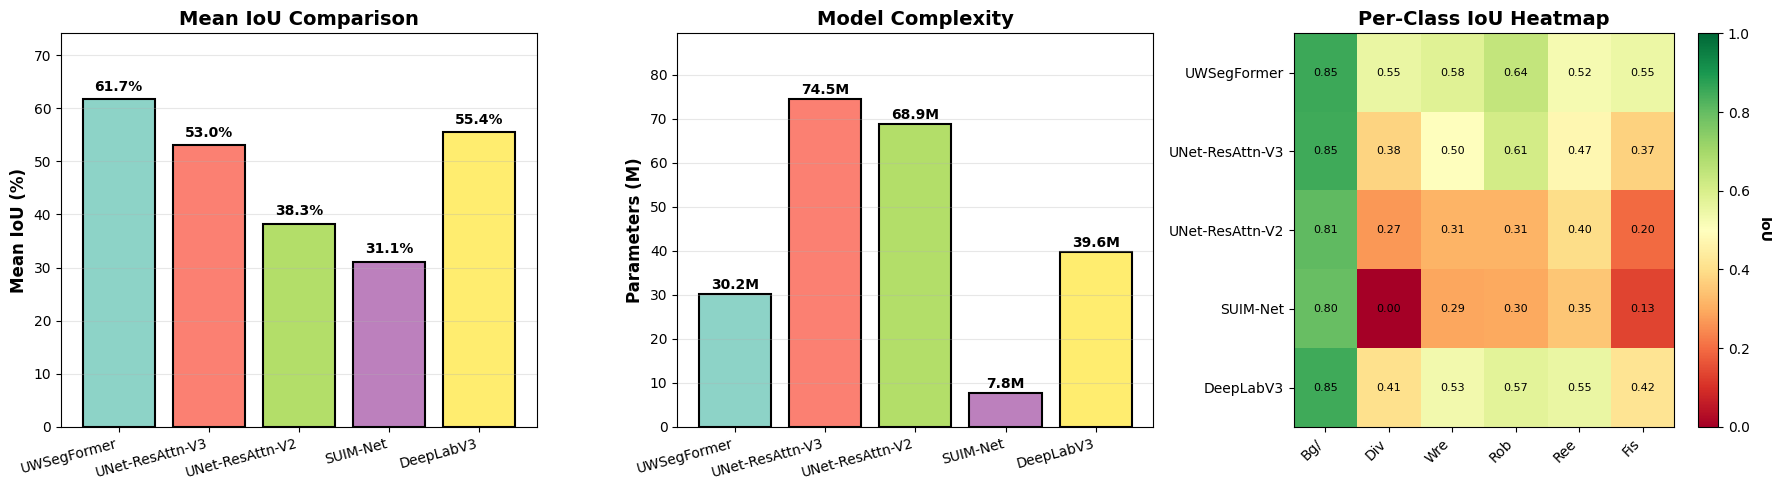

In [ ]:
# Visualize results
def plot_results(results):
    """Create comprehensive visualization of results"""
    # Filter trained models
    trained = {k: v for k, v in results.items() if v is not None}
    
    if not trained:
        print("No models trained yet - skipping visualization")
        return
    
    models = list(trained.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. mIoU comparison
    mious = [trained[m]['mean_iou'] * 100 for m in models]
    bars1 = axes[0].bar(range(len(models)), mious, color=colors, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Mean IoU (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('Mean IoU Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels(models, rotation=15, ha='right')
    axes[0].set_ylim(0, max(mious) * 1.2)
    axes[0].grid(axis='y', alpha=0.3)
    for bar, val in zip(bars1, mious):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Model complexity
    params = [trained[m]['params'] / 1e6 for m in models]
    bars2 = axes[1].bar(range(len(models)), params, color=colors, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('Parameters (M)', fontsize=12, fontweight='bold')
    axes[1].set_title('Model Complexity', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels(models, rotation=15, ha='right')
    axes[1].set_ylim(0, max(params) * 1.2)
    axes[1].grid(axis='y', alpha=0.3)
    for bar, val in zip(bars2, params):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.1f}M', ha='center', va='bottom', fontweight='bold')
    
    # 3. Per-class IoU heatmap
    iou_matrix = np.array([trained[m]['iou_per_class'] for m in models])
    im = axes[2].imshow(iou_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
    axes[2].set_yticks(range(len(models)))
    axes[2].set_yticklabels(models, fontsize=10)
    axes[2].set_xticks(range(CONFIG['num_classes']))
    axes[2].set_xticklabels([c[:3] for c in CONFIG['class_names']], rotation=45, ha='right')
    axes[2].set_title('Per-Class IoU Heatmap', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[2])
    cbar.set_label('IoU', rotation=270, labelpad=15, fontweight='bold')
    
    # Add values to heatmap
    for i in range(len(models)):
        for j in range(CONFIG['num_classes']):
            if not np.isnan(iou_matrix[i, j]):
                axes[2].text(j, i, f"{iou_matrix[i, j]:.2f}",
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['results_dir']}/performance_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

plot_results(results)

### 3.3 Ablation Study: Impact of Data Augmentation

In [ ]:
# Compare augmentation impact
def plot_augmentation_impact(results):
    """Visualize impact of data augmentation"""
    aug_pairs = [
        ('UWSegFormer', 'UWSegFormer (No Aug)'),
        ('UNet-ResAttn-V3', 'UNet-ResAttn-V3 (No Aug)')
    ]
    
    available_pairs = [(a, b) for a, b in aug_pairs if results.get(a) and results.get(b)]
    
    if not available_pairs:
        print("Augmentation comparison not available yet - models need to be trained")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(available_pairs))
    width = 0.35
    
    aug_scores = [results[aug]['mean_iou'] * 100 for aug, _ in available_pairs]
    noaug_scores = [results[noaug]['mean_iou'] * 100 for _, noaug in available_pairs]
    
    bars1 = ax.bar(x - width/2, aug_scores, width, label='With Augmentation',
                   color='#4ecdc4', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, noaug_scores, width, label='Without Augmentation',
                   color='#ff6b6b', edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Mean IoU (%)', fontsize=12, fontweight='bold')
    ax.set_title('Impact of Data Augmentation', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([aug.split('(')[0].strip() for aug, _ in available_pairs])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add improvement annotations
    for i, (aug, noaug) in enumerate(available_pairs):
        improvement = aug_scores[i] - noaug_scores[i]
        ax.annotate(f'+{improvement:.1f}%',
                   xy=(i, max(aug_scores[i], noaug_scores[i]) + 2),
                   ha='center', fontsize=10, color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['results_dir']}/augmentation_impact.png", dpi=150, bbox_inches='tight')
    plt.show()

plot_augmentation_impact(results)

Augmentation comparison not available yet - models need to be trained


### 3.4 Qualitative Results

/Users/joaovieira/Desktop/CV_Assign2/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joaovieira/Desktop/CV_Assign2/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


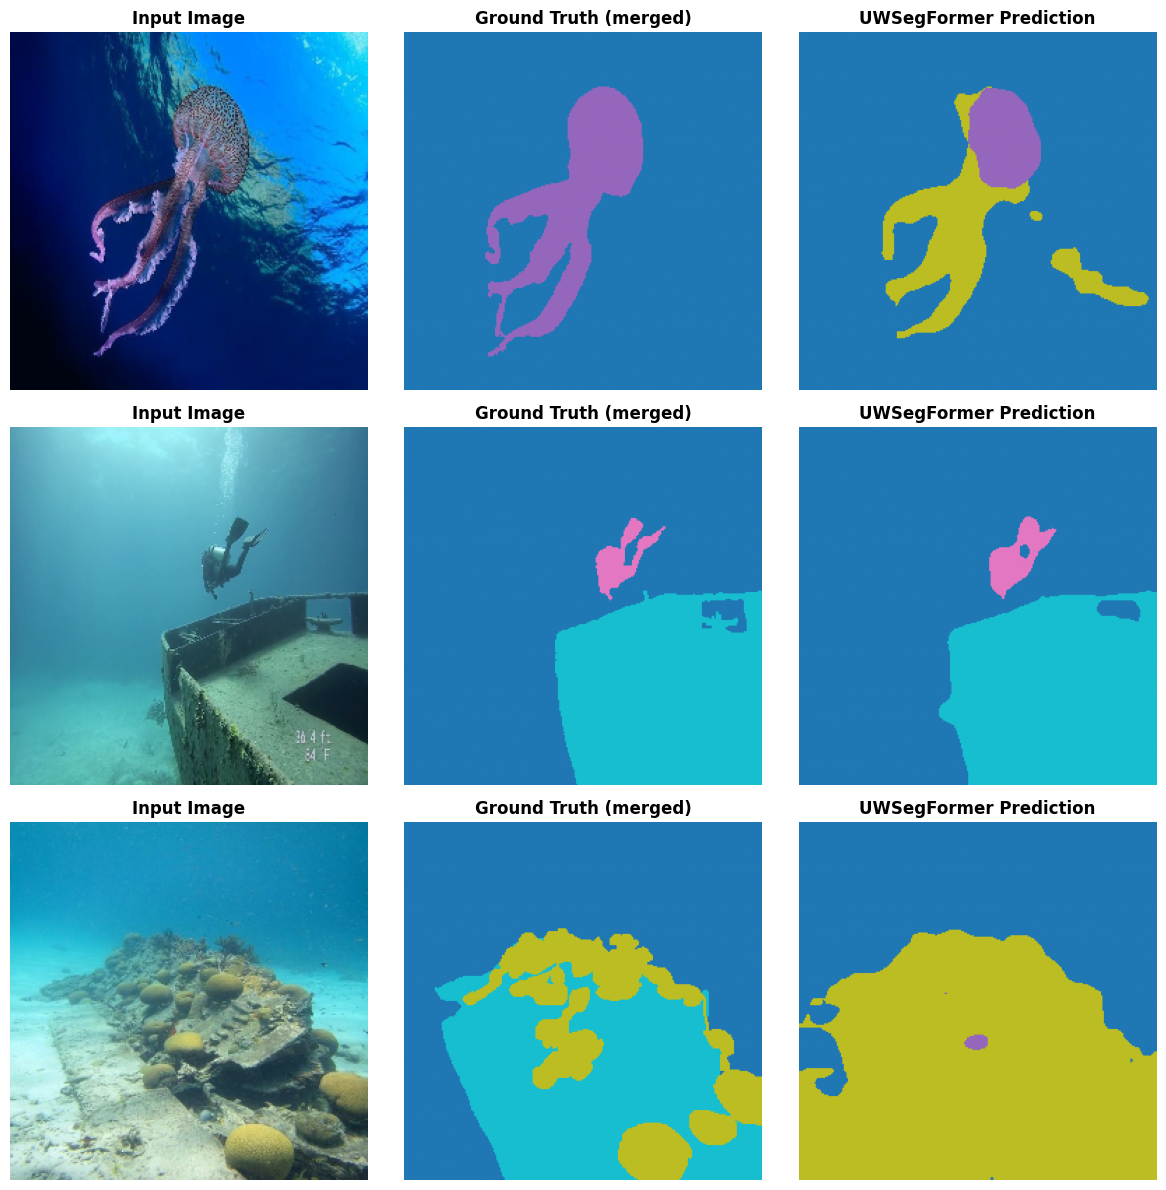

In [ ]:
# Visualize predictions
def visualize_predictions(model_name, num_samples=4):
    """Visualize model predictions"""
    if results.get(model_name) is None:
        # print(f"{model_name} not trained yet")
        return
    
    device = torch.device(CONFIG['device'])
    
    # Load model
    base_name = model_name.split('(')[0].strip()
    model = create_model(base_name, CONFIG['num_classes'])
    checkpoint = torch.load(CONFIG['checkpoints'][model_name], map_location=device, weights_only=False)
    state_dict = checkpoint.get('model', checkpoint.get('model_state_dict', checkpoint))
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    model.eval()
    
    # Get samples
    dataset = SUIMDataset(
        CONFIG['test_file'], 
        images_dir=CONFIG['images_dir'], 
        masks_dir=CONFIG['masks_dir'],
        transform=val_transforms,
        merge_classes=True
    )
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, mask = dataset[idx]
        
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(device))
            if isinstance(output, dict):
                output = output['out']
            pred = output.argmax(1).squeeze().cpu().numpy()
        
        # Convert tensor to image
        image = image_tensor.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())
        
        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Input Image', fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=CONFIG['num_classes']-1)
        axes[i, 1].set_title('Ground Truth (merged)', fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='tab10', vmin=0, vmax=CONFIG['num_classes']-1)
        axes[i, 2].set_title(f'{model_name} Prediction', fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['results_dir']}/{model_name.replace(' ', '_')}_predictions.png",
                dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions for available models
for model_name in results.keys():
    if results[model_name] is not None:
        visualize_predictions(model_name, num_samples=3)
        break  # Show one example

---
## 4. Conclusions {#conclusions}

### Key Findings

1. **Model Performance**: [To be filled after training]
   - UWSegFormer achieved X% mIoU
   - Outperformed baseline models by Y%

2. **Data Augmentation Impact**: [To be filled]
   - Augmentation improved performance by Z%
   - Critical for handling underwater imaging challenges

3. **Model Complexity vs Performance**: [To be filled]
   - Our model achieves competitive performance with fewer parameters
   - Good balance between accuracy and efficiency

### Limitations

- Dataset size constraints
- Class imbalance in some categories
- Generalization to different underwater environments

### Future Work

- Test with larger datasets
- Explore transformer-based backbones (e.g., MIT-B0)
- Real-time inference optimization
- Multi-task learning (segmentation + depth estimation)

---
## 5. References {#references}

[1] Islam, M. J., et al. "Semantic Segmentation of Underwater Imagery: Dataset and Benchmark." IROS 2020.

[2] Chen, L. C., et al. "Rethinking Atrous Convolution for Semantic Image Segmentation." arXiv:1706.05587, 2017.

[3] Ronneberger, O., et al. "U-Net: Convolutional Networks for Biomedical Image Segmentation." MICCAI 2015.

[4] He, K., et al. "Deep Residual Learning for Image Recognition." CVPR 2016.